In [1]:
# Cell 1: Setup
"""
Notebook 5: Explainable AI Integration
Grad-CAM, Grad-CAM++, LIME visualizations
"""

import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from pathlib import Path

from src.models.custom_architectures import build_model
from src.explainability.gradcam import (
    GradCAM, GradCAMPlusPlus, LayerCAM,
    visualize_gradcam, compare_cam_methods, get_target_layer
)
from src.explainability.lime_explainer import LIMEExplainer
from src.data.dataset import get_transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

CLASS_NAMES = ['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4']

/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Device: cuda


In [7]:
# Cell 2: Load Best Model
"""
Load best performing model for XAI analysis
"""

checkpoint = torch.load('../models/saved_models/efficientnet_b4_baseline.pth')
config = checkpoint['config']

model = build_model(config).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f" Loaded model: {config['model_name']}")
print(f"Test Accuracy: {checkpoint['test_metrics']['accuracy']:.4f}")

 Loaded model: efficientnet_b4
Test Accuracy: 0.6736


In [8]:
# Cell 3: Load Sample Images
"""
Load sample images from each grade
"""

import pandas as pd

test_metadata = pd.read_csv('../data/processed/test_metadata.csv')

# Select one sample from each grade
sample_images = {}
sample_paths = {}

for grade in range(5):
    grade_samples = test_metadata[test_metadata['grade'] == grade]
    sample_path = grade_samples.iloc[0]['image_path']
    
    # Load image
    img = cv2.imread(sample_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    sample_images[grade] = img_rgb
    sample_paths[grade] = sample_path

print(" Loaded sample images from each grade")


 Loaded sample images from each grade


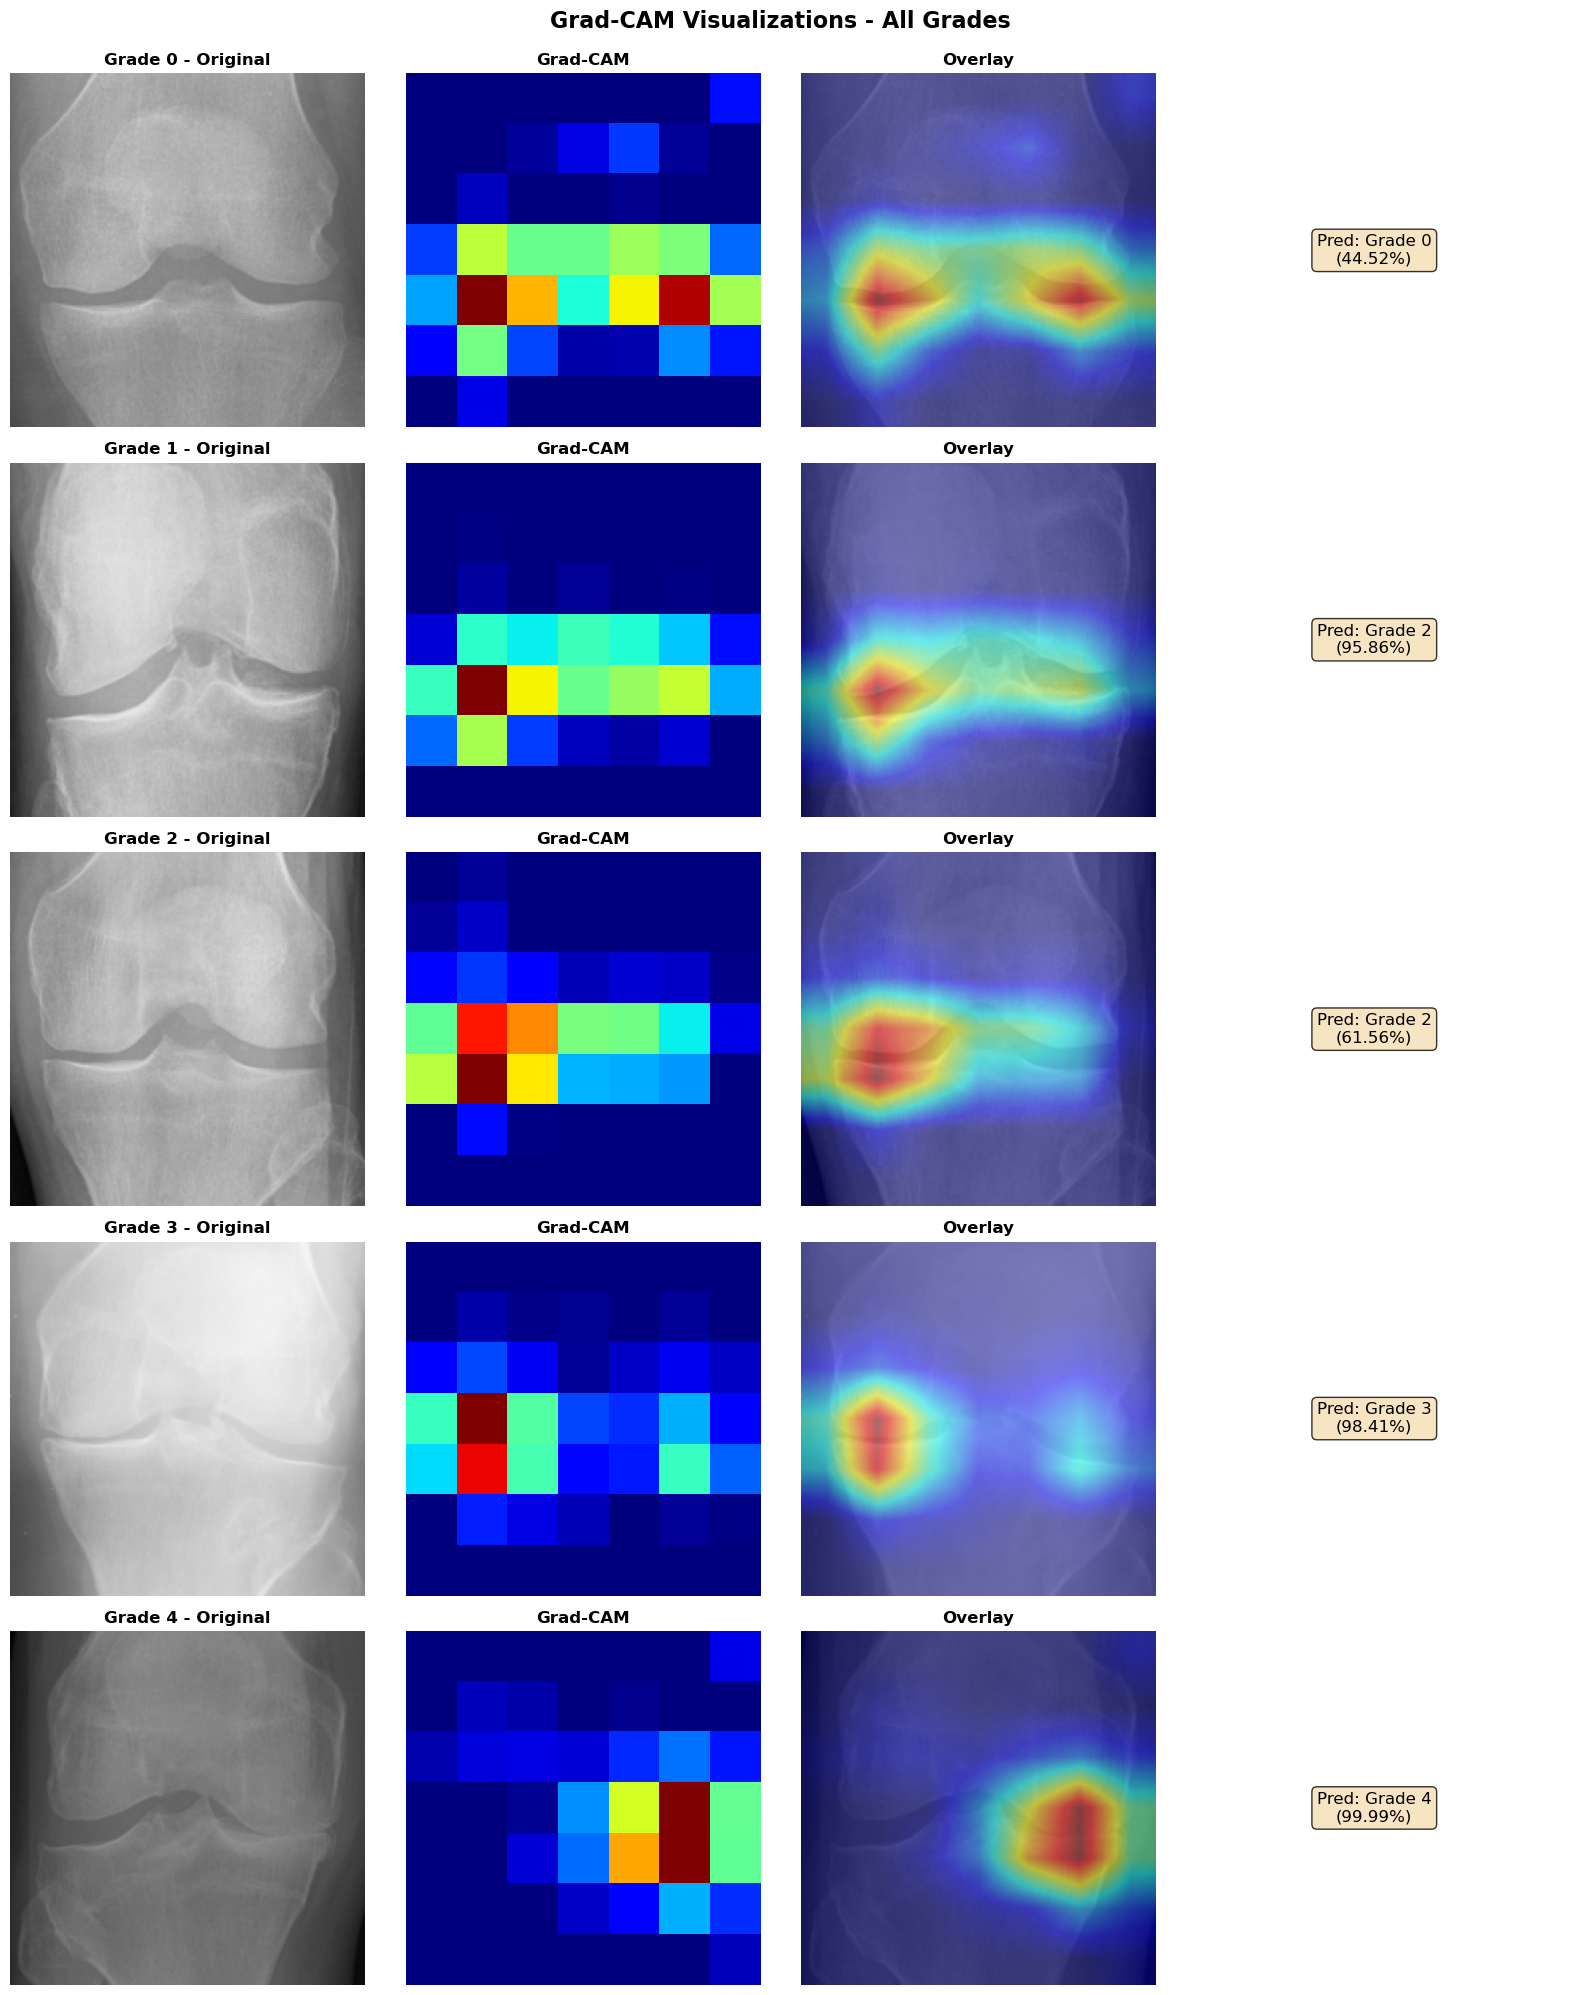

In [10]:
# Cell 4: Grad-CAM Visualization
"""
Generate Grad-CAM visualizations for all samples
"""

# Get target layer
target_layer = get_target_layer(model, config['model_name'])

# Preprocessing
transform = get_transforms(224, augment=False)

fig, axes = plt.subplots(5, 4, figsize=(16, 20))

for grade in range(5):
    # Load and preprocess image
    img_rgb = sample_images[grade]
    augmented = transform(image=img_rgb)
    img_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Resize for visualization
    img_resized = cv2.resize(img_rgb, (224, 224))
    
    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)
    
    # Generate CAM
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, 1)[0]
        pred_class = output.argmax(1).item()
    
    cam = gradcam.generate_cam(img_tensor, pred_class)
    
    # Overlay
    from src.explainability.gradcam import overlay_heatmap
    overlayed = overlay_heatmap(img_resized, cam, alpha=0.5)
    
    # Plot
    axes[grade, 0].imshow(img_resized)
    axes[grade, 0].set_title(f'Grade {grade} - Original', fontweight='bold')
    axes[grade, 0].axis('off')
    
    axes[grade, 1].imshow(cam, cmap='jet')
    axes[grade, 1].set_title(f'Grad-CAM', fontweight='bold')
    axes[grade, 1].axis('off')
    
    axes[grade, 2].imshow(overlayed)
    axes[grade, 2].set_title(f'Overlay', fontweight='bold')
    axes[grade, 2].axis('off')
    
    # Prediction info
    pred_text = f"Pred: Grade {pred_class}\n({probs[pred_class]:.2%})"
    axes[grade, 3].text(0.5, 0.5, pred_text, ha='center', va='center',
                       fontsize=12, transform=axes[grade, 3].transAxes,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[grade, 3].axis('off')
    
    gradcam.remove_hooks()

plt.suptitle('Grad-CAM Visualizations - All Grades', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../reports/figures/gradcam_all_grades.png', dpi=300, bbox_inches='tight')
plt.show()


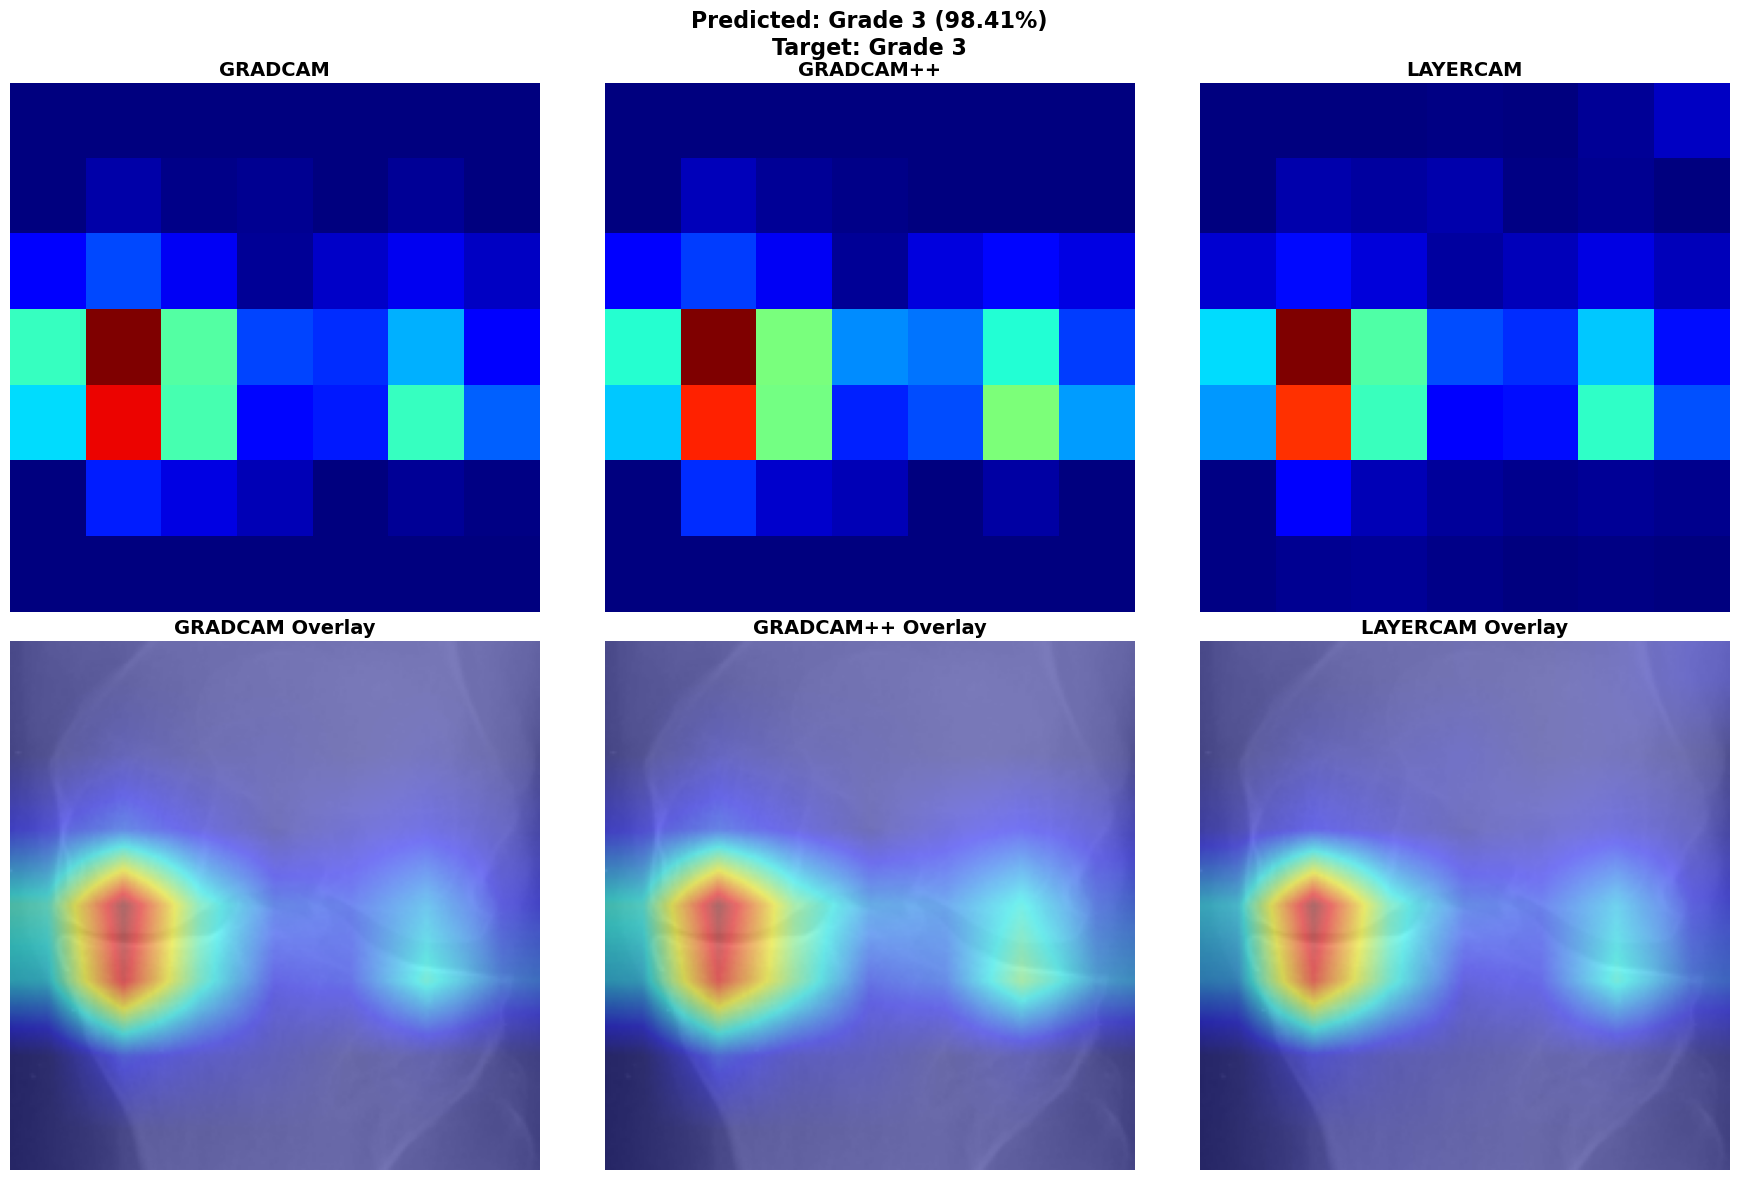

In [11]:
# Cell 5: Compare CAM Methods
"""
Compare Grad-CAM, Grad-CAM++, and Layer-CAM
"""

# Select Grade 3 sample for detailed comparison
test_grade = 3
img_rgb = sample_images[test_grade]

augmented = transform(image=img_rgb)
img_tensor = augmented['image'].unsqueeze(0).to(device)
img_resized = cv2.resize(img_rgb, (224, 224))

compare_cam_methods(
    model=model,
    image=img_tensor,
    original_image=img_resized,
    target_layer=target_layer,
    class_names=CLASS_NAMES,
    target_class=None,
    save_path='../reports/figures/cam_methods_comparison.png'
)

Generating LIME explanation for Grade 0...


  0%|          | 0/500 [00:00<?, ?it/s]

Generating LIME explanation for Grade 1...


  0%|          | 0/500 [00:00<?, ?it/s]

Generating LIME explanation for Grade 2...


  0%|          | 0/500 [00:00<?, ?it/s]

Generating LIME explanation for Grade 3...


  0%|          | 0/500 [00:00<?, ?it/s]

Generating LIME explanation for Grade 4...


  0%|          | 0/500 [00:00<?, ?it/s]

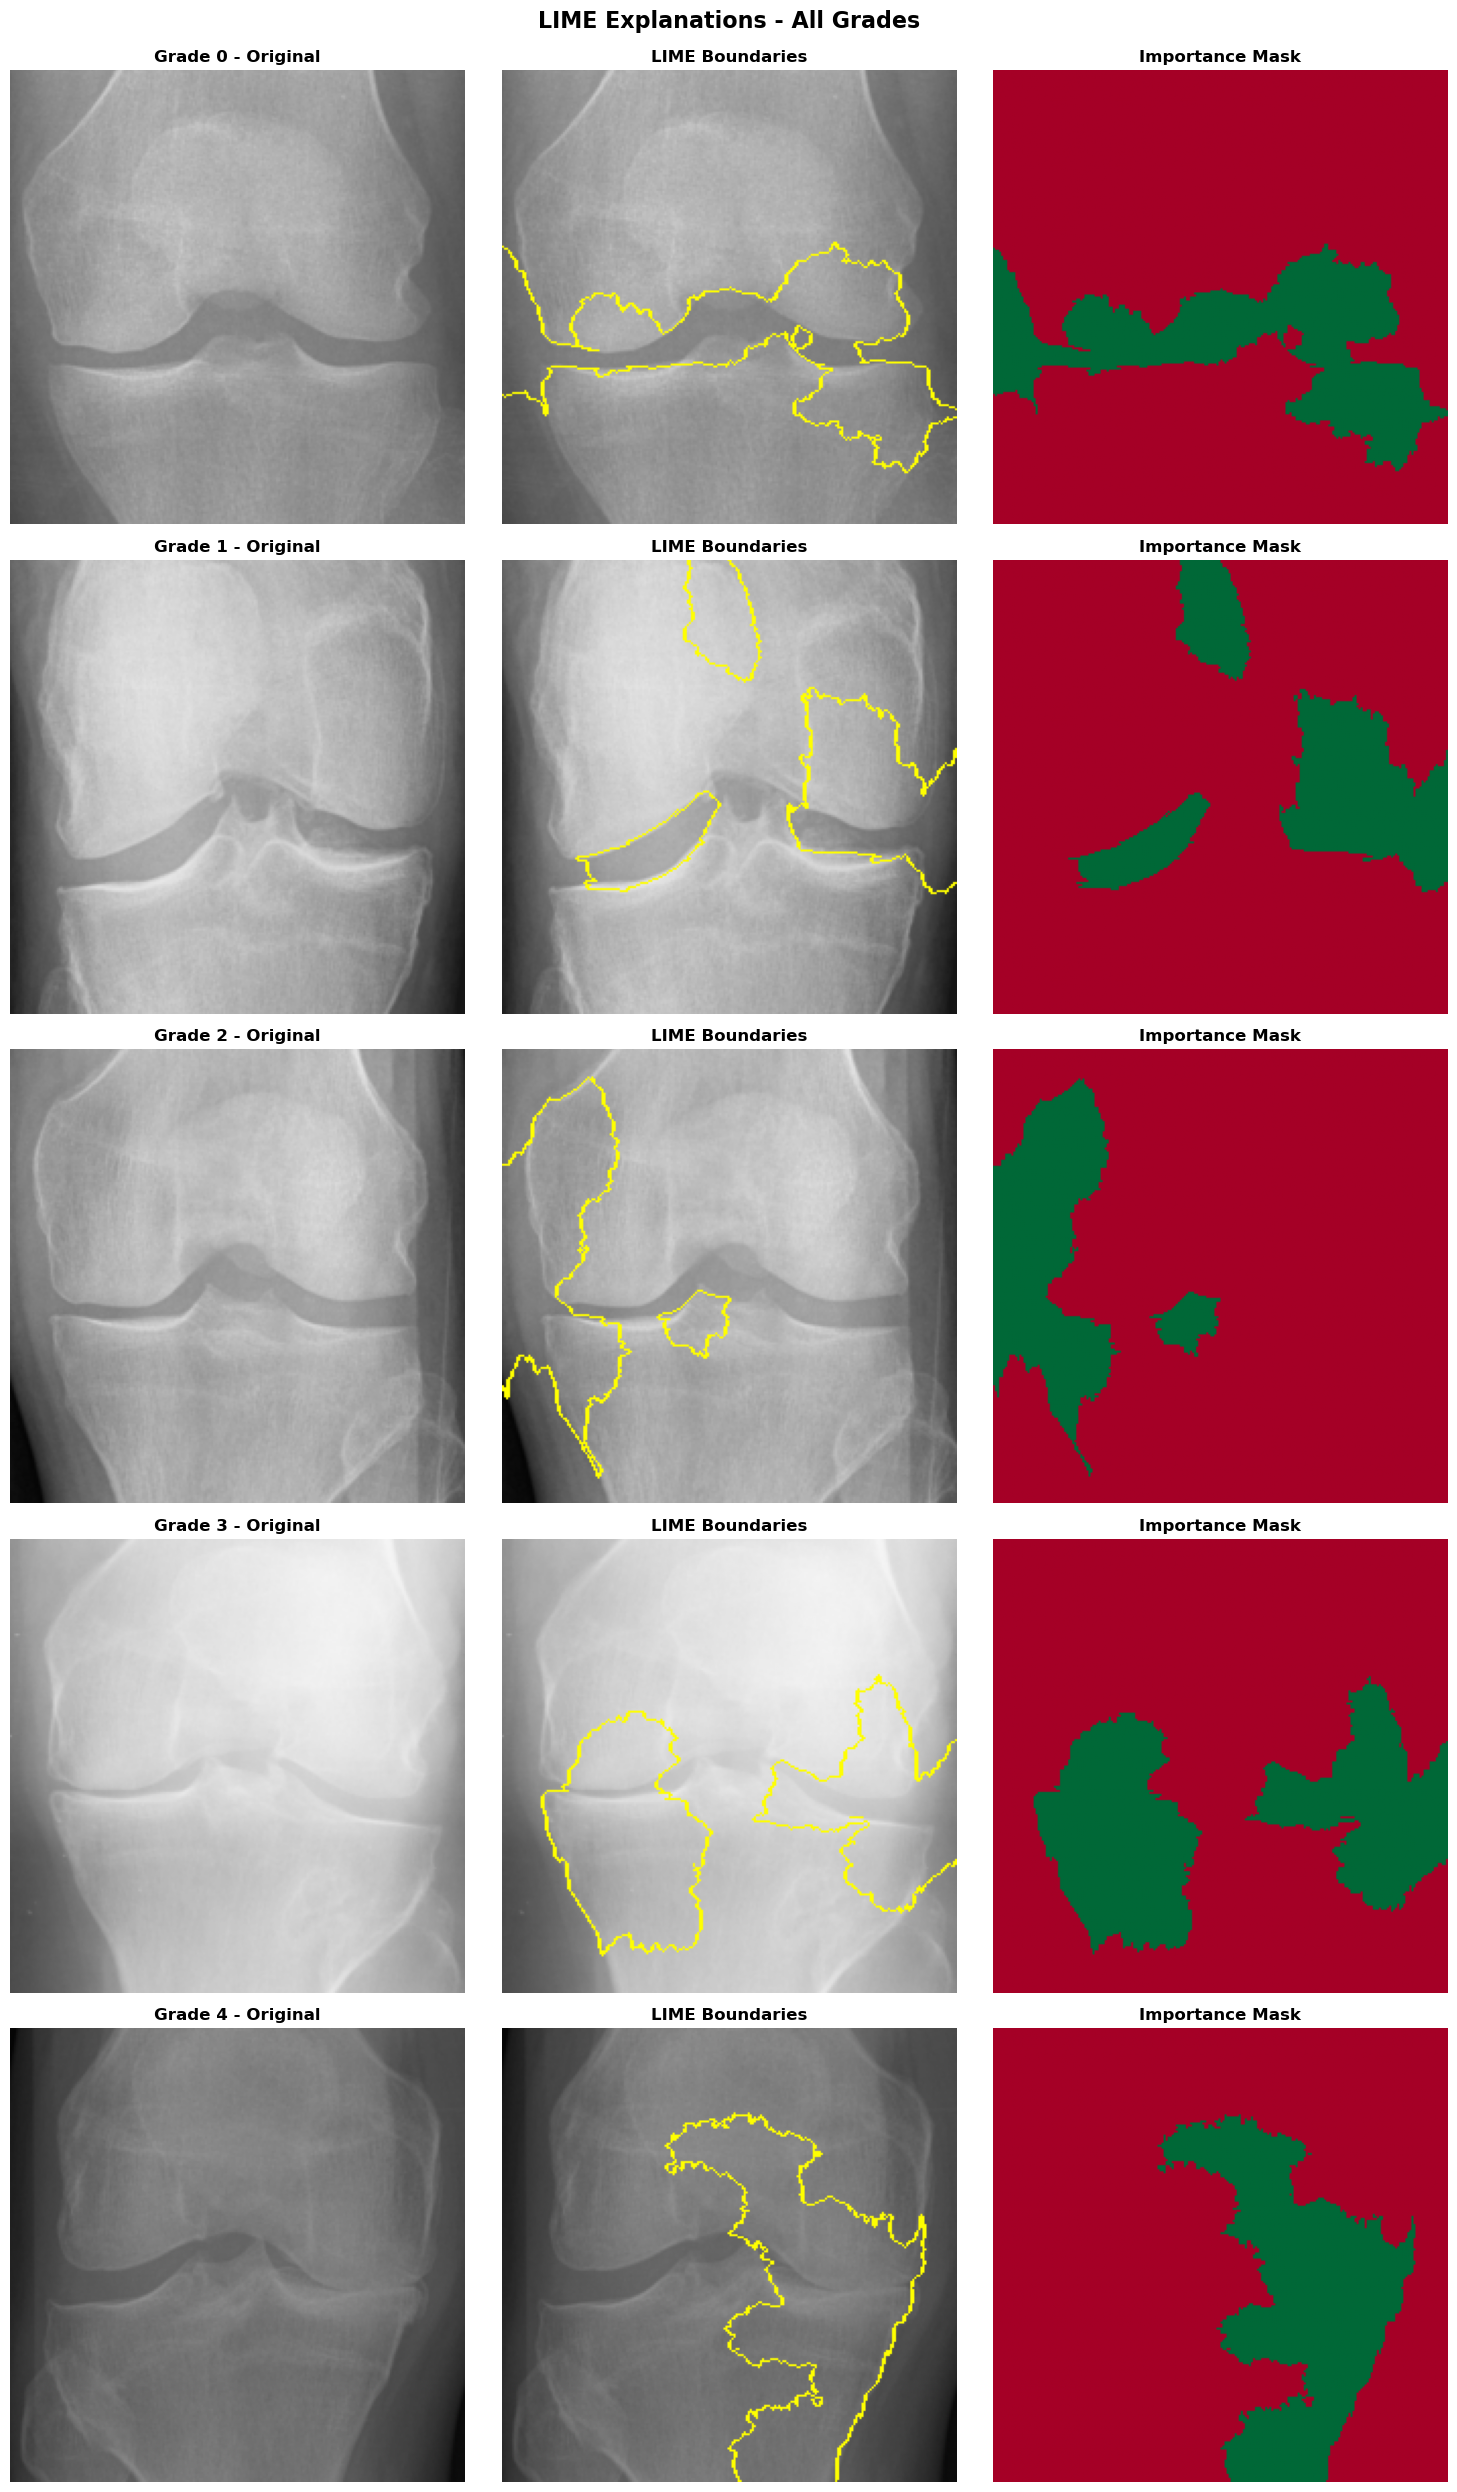

In [14]:
# Cell 6: LIME Explanations
"""
Generate LIME explanations
"""

# Preprocessing function for LIME
def preprocess_for_lime(pil_img):
    img_np = np.array(pil_img)
    augmented = transform(image=img_np)
    return augmented['image']

# Initialize LIME explainer
lime_explainer = LIMEExplainer(model, preprocess_for_lime, device)

# Generate explanations for each grade
fig, axes = plt.subplots(5, 3, figsize=(15, 25))

for grade in range(5):
    img_rgb = sample_images[grade]
    img_resized = cv2.resize(img_rgb, (224, 224))
    
    print(f"Generating LIME explanation for Grade {grade}...")
    
    # Generate explanation
    explanation = lime_explainer.explain_instance(
        img_resized,
        top_labels=3,
        num_samples=500,
        num_features=5
    )
    
    # Get image and mask
    temp, mask = explanation.get_image_and_mask(
        grade,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    
    # Plot
    axes[grade, 0].imshow(img_resized)
    axes[grade, 0].set_title(f'Grade {grade} - Original', fontweight='bold')
    axes[grade, 0].axis('off')
    
    from skimage.segmentation import mark_boundaries
    axes[grade, 1].imshow(mark_boundaries(temp / 255.0, mask))
    axes[grade, 1].set_title(f'LIME Boundaries', fontweight='bold')
    axes[grade, 1].axis('off')
    
    axes[grade, 2].imshow(mask, cmap='RdYlGn', vmin=0, vmax=1)
    axes[grade, 2].set_title(f'Importance Mask', fontweight='bold')
    axes[grade, 2].axis('off')

plt.suptitle('LIME Explanations - All Grades', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../reports/figures/lime_all_grades.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# Cell 7: XAI Comparison Summary
"""
Create XAI comparison table
"""

xai_summary = {
    'Method': ['Grad-CAM', 'Grad-CAM++', 'Layer-CAM', 'LIME'],
    'Type': ['Gradient-based', 'Gradient-based', 'Gradient-based', 'Perturbation-based'],
    'Speed': ['Fast', 'Fast', 'Fast', 'Slow'],
    'Precision': ['Medium', 'High', 'High', 'High'],
    'Interpretability': ['High', 'High', 'High', 'Very High'],
    'Use Case': [
        'Quick visualization',
        'Detailed localization',
        'Fine-grained attention',
        'Feature importance'
    ]
}

xai_df = pd.DataFrame(xai_summary)
display(xai_df)

xai_df.to_csv('../reports/tables/xai_methods_comparison.csv', index=False)

print("\n✅ XAI Integration Complete!")
print("="*60)
print("Generated visualizations:")
print("  - Grad-CAM for all grades")
print("  - CAM methods comparison")
print("  - LIME explanations for all grades")
print("="*60)

,Method,Type,Speed,Precision,Interpretability,Use Case
0,Grad-CAM,Gradient-based,Fast,Medium,High,Quick visualization
1,Grad-CAM++,Gradient-based,Fast,High,High,Detailed localization
2,Layer-CAM,Gradient-based,Fast,High,High,Fine-grained attention
3,LIME,Perturbation-based,Slow,High,Very High,Feature importance



✅ XAI Integration Complete!
Generated visualizations:
  - Grad-CAM for all grades
  - CAM methods comparison
  - LIME explanations for all grades
